In [1]:
import numpy as np
from six.moves import urllib
import os
import tensorflow as tf
import pickle

DATA_DIRECTORY = "data"
SOURCE_URL = 'http://35.183.27.27/'

def maybe_download(filename):
    """Download the data, unless it's already here."""
    if not tf.gfile.Exists(DATA_DIRECTORY):
        tf.gfile.MakeDirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)     
    if not tf.gfile.Exists(filepath):
        print('Start downloading dataset...')
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)         
        with tf.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

def dense_to_one_hot(labels_dense, num_classes = 3):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def load_data(filename, one_hot=False):
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        data = dict['data']
        labels = dict['label']

        if one_hot:
            labels = dense_to_one_hot(labels)
        return data, labels

class DataSet(object):
    def __init__(self, data, labels):
        assert data.shape[0] == labels.shape[0], ("data.shape: %s labels.shape: %s" % (data.shape, labels.shape))
        self._num_examples = data.shape[0]

        self._data = data
        self._lables = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def data(self):
        return self._data

    @property
    def labels(self):
        return self._lables

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._data = self._data[perm]
            self._lables = self._lables[perm]

            start = 0

            self._index_in_epoch = batch_size

            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._data[start:end], self._lables[start:end]

def read_data_sets(one_hot=False):
    class DataSets(object):
        pass
    train_filename = maybe_download('train')
    test_filename = maybe_download('test')

    train_data, train_labels = load_data(train_filename, one_hot)
    test_data, test_labels = load_data(test_filename, one_hot)
    data_sets = DataSets()
    data_sets.train = DataSet(train_data, train_labels)
    data_sets.test = DataSet(test_data, test_labels)
    return data_sets

In [2]:
# return DataSet class
data = read_data_sets(one_hot=True)

# get train data and labels by batch size
train_x, train_label = data.train.next_batch(30000)

# get test data
test_x = data.test.data

# get test labels
test_labels = data.test.labels

# get sample number
n_samples = data.train.num_examples


Start downloading dataset...
Successfully downloaded train 209530726 bytes.
Start downloading dataset...
Successfully downloaded test 144273978 bytes.


In [8]:
print(test_labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate

def LucasCoordConv():
    """Return LucasCoordConv implementation.
    Returns
    -------
    Sequential keras model
        Model.
    """
    seq_length = 62
    kernel_size = 3
    activation = "relu"
    padding = "valid"

    inp = Input(shape=(seq_length, 5))

    # CoordCONV1
    #x = CoordinateChannel1D()(inp)
    x = Conv1D(filters=28,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(inp)
    x = MaxPooling1D(2)(x)

    # CONV2
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV3
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV4
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # Flatte, FC1, FC2, Softmax
    x = Flatten()(x)
    x = Dense(62, activation=activation)(x)
    x = Dense(28, activation=activation)(x)
    x = Dense(3, activation="softmax")(x)

    return Model(inputs=inp, outputs=x)

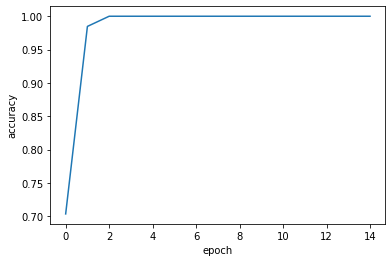

[[4.58934010e-05 1.03147555e-23 9.99954104e-01]
 [4.90620041e-05 1.11774924e-23 9.99950886e-01]
 [5.03396368e-05 1.19748162e-23 9.99949694e-01]
 ...
 [9.82485294e-01 1.75147261e-02 4.37209383e-12]
 [9.80527639e-01 1.94723923e-02 4.67974401e-12]
 [9.80131567e-01 1.98683925e-02 4.78875837e-12]]
3000/3000 [==============================] - 1s 218us/sample - loss: 4.2677e-07 - categorical_accuracy: 1.0000
[4.267663063970417e-07, 1.0]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[16394. 22172. 19555.]


In [16]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
predict_global=None
def lucas_classification(model_name="LucasCNN", batch_size=32,
                         epochs=15, random_state=None, verbose=0):
    run = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + model_name

    # 0. set random states
    np.random.seed(random_state)
    #tf.random.set_seed(random_state+1)

    # 1. get data
    X_train= np.reshape(train_x,(30000,62,5))
    #X_val 
    y_train=train_label
    #y_val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)


    # 2. get model
    model = LucasCoordConv()

    # 3. set up callbacks
    tensorboard = TensorBoard(
        log_dir='./logs/'+run,
        write_graph=True,
        write_grads=True,
        write_images=True,
        update_freq='epoch',
        histogram_freq=5)
    earlystopping = EarlyStopping(monitor="val_accuracy", patience=40)

    # 4. compile
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["categorical_accuracy"])

    # 5. fit to data
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        #validation_data=(X_val, y_val),
        callbacks=[tensorboard, earlystopping])

    plt.plot(history.history['categorical_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    # 6. calculate score
    X_test = np.reshape(test_x, (test_x.shape[0],62,5))
    predict = model.predict(X_test)
    print(predict)

    score = model.evaluate(X_val, y_val, batch_size=batch_size)
    return score,predict


if __name__ == '__main__':
    score,predict = lucas_classification()
    print(score)
    predict_global= np.around(predict)
    predict_sum=np.sum(predict_global,axis=0)
    print(predict_global)
    print(predict_sum)

In [0]:
predict_sum=np.around(np.sum(predict_global,axis=0))


In [15]:
print(predict_sum)

[14900. 27249. 15901.]
